# Tutorial 2: Social Media & Valuation of Landscapes

Within this tutorial, we will work with the Flickr photo database to better understand how people value specific land use types. We will learn how to extract information from Flickr, how you can explore and visualize this, and how to use it for some basic analysis.

### Important before we start
---
Make sure that you save this file before you continue, else you will lose everything. To do so, go to **Bestand/File** and click on **Een kopie opslaan in Drive/Save a Copy on Drive**!

Now, rename the file into Week6_Tutorial2.ipynb. You can do so by clicking on the name in the top of this screen.


## Learning Objectives
<hr>

- To understand how we can use public data to better understand people's preferences for leisure.
- To know how to extract data from Flickr using an API.
- To know how to clean and prepare raw data for analysis.
- To know how to cluster geospatial information.
- To visualize clusters and point data in a meaningful way.
- To know how to combine different spatial datasets to gain additional insights.

<h2>Tutorial Outline<span class="tocSkip"></span></h2>
<hr>
<div class="toc"><ul class="toc-item">
<li><span><a href="#introducing-the-packages" data-toc-modified-id="1.-Introducing-the-packages-2">1. Introducing the packages</a></span></li>
<li><span><a href="#extract-data-from-flickr" data-toc-modified-id="2.-Extracting-flickr-data-3">2. Extract data from Flickr</a></span></li>
<li><span><a href="#explore-the-data" data-toc-modified-id="3.-Explore-Data-4">3. Explore the data</a></span></li>
<li><span><a href="#clustering-of-data" data-toc-modified-id="4.-Cluster-data-5">4. Clustering of data</a></span></li>
<li><span><a href="#do-people-prefer-certain-land-uses?" data-toc-modified-id="5.-Analyze-buildings-6">5. Do people prefer certain land uses? </a></span></li></ul></div>

## 1.Introducing the packages
<hr>

Within this tutorial, we are going to make use of the following packages: 

[**flickrapi**](https://stuvel.eu/flickrapi-doc/index.html) is a Python interface to the Flickr API. It includes support for authorized and non-authorized access, uploading and replacing photos, and all Flickr API functions.

[**GeoPandas**](https://geopandas.org/) is a Python package that extends the datatypes used by pandas to allow spatial operations on geometric types.

[**NumPy**](https://numpy.org/doc/stable/) is a Python library that provides a multidimensional array object, various derived objects, and an assortment of routines for fast operations on arrays.

[**Pandas**](https://pandas.pydata.org/docs/) is an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

[**OSMnx**](https://osmnx.readthedocs.io/) is a Python package that lets you download geospatial data from OpenStreetMap and model, project, visualize, and analyze real-world street networks and any other geospatial geometries. You can download and model walkable, drivable, or bikeable urban networks with a single line of Python code then easily analyze and visualize them. You can just as easily download and work with other infrastructure types, amenities/points of interest, building footprints, elevation data, street bearings/orientations, and speed/travel time.

[**Matplotlib**](https://matplotlib.org/) is a comprehensive Python package for creating static, animated, and interactive visualizations in Python. Matplotlib makes easy things easy and hard things possible.

*We will first need to install these packages in the cell below. Uncomment them to make sure we can pip install them*

In [ ]:
!pip install flickrapi
!pip install osmnx
!pip install contextily

Now we will import these packages in the cell below:

In [2]:
import flickrapi
import pygeos
import pandas as pd
import contextily as cx
import geopandas as gpd
import osmnx as ox
import numpy as np

from sklearn.cluster import DBSCAN
from datetime import datetime

## 2. Extract data from Flickr
<hr>

To extract data from Flicker, we will use their **API**. This is an acronym for application programming interface. It is a software intermediary that allows two applications to talk to each other. APIs are an accessible way to extract and share data within and across organizations. APIs are all around us. Every time you use a rideshare app, send a mobile payment, or change the thermostat temperature from your phone, you’re using an API.

However, before we can access this **API**, we need to take a few steps. Most importantly, we need to register ourselves on the [Flickr](https://www.flickr.com/) portal. To do so, we need to register, as explained in the video clip below:

<img src="https://github.com/ElcoK/BigData_AED/blob/main/_static/images/Flickr_registration.gif?raw=1" class="bg-primary mb-1">
<br>

Now, the next step is to access the API. You can now login on the website of [Flickr](https://www.flickr.com/), and go to the **API** part of the [website](https://www.flickr.com/services/apps/create/apply/?).

Now click on `APPLY FOR A NON-COMMERCIAL KEY` and just fill in some information about the course. The name of the App can be something random and related to our big data course, and you just need to fill in two lines of text to describe what you want to do. As soon as you click `SUBMIT`, you will see a generated **api_key** and an **api_secret**. Fill those in below.

In [3]:
api_key = ''
api_secret=''

flickr = flickrapi.FlickrAPI(api_key, api_secret, cache=True)

### Prepare data extraction

Before we get started with the extraction of data, we need to specify again an area of interest we want to focus on. In the cell below, you will now read "Ameland, The Netherlands". Change this to any random or municipality in the Netherlands that (1) you can think of and (2) will work. 

In some cases, the function does not recognize the location. You could either try a different phrasing or try a different location. Many parts of the Netherlands should work. It is also fine to use an area outside of the Netherlands. I would make sure to not make it too large, as it will take a long time to extract the photos.

In [4]:
place_name = "Ameland, The Netherlands"
area = ox.geocode_to_gdf(place_name)

Now let us visualize the bounding box of the area, similar to some of our previous tutorials.

Text(0.5, 1.0, 'Ameland, The Netherlands. Total area: 161 km2')

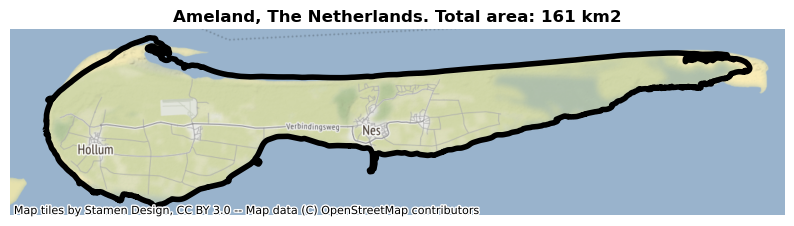

In [5]:
area_to_check = area.to_crs(epsg=3857)
ax = area_to_check.plot(figsize=(10, 10), color="none", edgecolor="k", linewidth=4)
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()
cx.add_basemap(ax, zoom=12) #depending on the size of your area, you may need to change the zoom level if you run into an error.
size = int(area_to_check.area/1e6)

ax.set_title("{}. Total area: {} km2".format(place_name,size),fontweight='bold')

<div class="alert alert-block alert-success">
<b>Question 1:</b> Provide the plot of your chosen area.
</div>

### Data extraction

To extract the metadata of the photos from Flickr, we are going to use the `.walk()` function. This function will return a list of photos matching some criteria. It allows you to search photos based on location, date, tag and so on.

In our case, we are state that we want to find all photos, no matter how they are tagged. This is defined through `tag_mode=all`. Moreover, as you will see, we also specify that we want some extra information. More specifically, we ask for the `geo(location)`, `tags`, `date_taken` and the `url_m` of a photo.

We use a bounding box `bbox` to make sure we only select photos from our region of interest. The input requires our bounding box to me in a string format. So let's do that first.

In [6]:
bbox_string = ",".join([str(x) for x in area.bounds.values[0]])

And now we can extract all the photos. We collect all of them in a list, through the `.append()` function

In [7]:
collect_pictures = []
for photo in flickr.walk(tag_mode='any',
                         #tags='nature',
                         bbox=bbox_string,extras='geo,tags,date_taken,url_m'):
    
    get_attributes = photo.attrib
    collect_pictures.append([get_attributes['id'],
                             get_attributes['owner'],
                             get_attributes['datetaken'],
                             get_attributes['tags'],
                             get_attributes['latitude'],
                             get_attributes['longitude']])

In [8]:
len(collect_pictures)

6800

## 3. Explore the data
<hr>
Now we have extracted the data and, let's explore (and clean) this data a bit more. The convenient thing of having everything stored in a list, is that we can easily turn this into a pandas DataFrame.

In [9]:
df = pd.DataFrame(collect_pictures,columns=['id','owner','datetaken','tags','latitude','longitude'])

In [ ]:
df.to_csv('Ameland_Flickr.csv')

Now let's explore the data a little bit:

In [ ]:
df.head(XXX)

And let's see if everything is stored in a format in which we can work with:

In [ ]:
df.dtypes

We would expect floating values for the **latitude** and **longitude**, and a *datetime* object for the **datetaken**. Let's have a look how these are stored: 

In [ ]:
df.longitude.iloc[0]

Aha! Strings. It will be difficult to convert strings into proper geometries, so let's convert these columns to floating values, and convert them to **points** using `pygeos.points()`. As you will see, we use a [list comprehension](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions) to do so. The input for `pygeos.points()` is a list or numpy array, in which each element contains a *longitude* and a *latitude*. To make sure we have that, we create this `list` using the [zip](https://docs.python.org/3.3/library/functions.html#zip) function in Python.

<div class="alert alert-block alert-success">
<b>Question 2:</b> As all the data is stored in strings, its pretty difficult to do something with the information straight away. Please provide the lines of code that you have written to convert the geo-information (lattitude and longitude) into actual coordinates and also provide the lines of code that you have written to convert the dates to a datetime object. Explain the lines of code.
</div>


In [22]:
df['longitude'] = df['longitude'].astype(
df['latitude'] = df['latitude'].
df['geometry'] = [pygeos.points(x[0],x[1]) for x in list(zip(df['longitude'],df['latitude']))]

Now let's convert the **datetaken** column into a *datetime* type, so we can extract specific years or days. To do so, we will make use of the `lambda` and `apply` functions, and use the `fromisoformat()` function from within the **datetime** package.

In [ ]:
df['datetaken'] = df.datetaken.XXXX(XXXX x : datetime.XXXX(x))
df['year'] = df.datetaken.dt.year
df['month'] = df.datetaken.dt.strftime('%b')
df['month_year'] = df['datetaken'].dt.to_period('M')

Now we have the dates in the correct format, we can plot a figure to identify when most of the photos have been taken/uploaded. 

<AxesSubplot:>

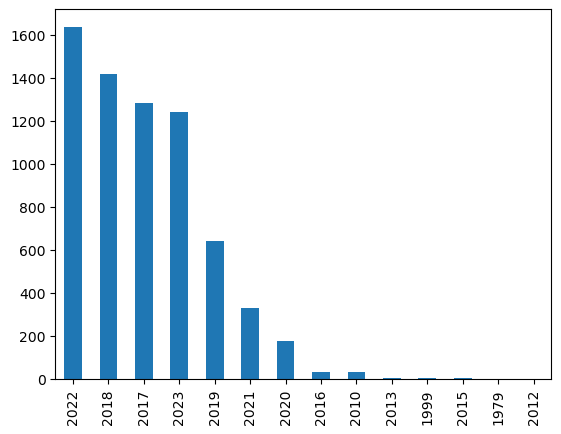

In [15]:
df.year.value_counts().plot(kind='bar')

As we are dealing with spatial data, it would be nice to plot this information on a map. To do so, we convert our `pandas.DataFrame` into a `geopandas.GeoDataFrame`. Moreover, we have to specify the coordinate reference system. Given that we have a global dataset, it makes most sense to use **epsg:4326**.

In [16]:
gdf = gpd.GeoDataFrame(df.copy())
gdf.crs = 'epsg:4326'

In [20]:
gdf

,id,owner,datetaken,tags,latitude,longitude,geometry,year,month,month_year
0,52717036566,8866365@N08,2022-03-18 16:24:18,ameland ballumerbocht friesland nederland bird...,53.429979,5.702633,POINT (5.70263 53.42998),2022,Mar,2022-03
1,52712145777,57755771@N05,2022-08-07 19:43:59,düne pflanzen ameland friesland europa landsch...,53.460438,5.762622,POINT (5.76262 53.46044),2022,Aug,2022-08
2,52709531717,57755771@N05,2022-08-07 19:43:38,düne strand pflanzen ameland friesland europa ...,53.460438,5.762622,POINT (5.76262 53.46044),2022,Aug,2022-08
3,52702770036,57755771@N05,2022-08-07 19:48:41,pflanzen ameland friesland europa landschaft n...,53.460438,5.762622,POINT (5.76262 53.46044),2022,Aug,2022-08
4,52700137342,57755771@N05,2022-08-07 20:02:50,ameland meer europa vogel wasser tier natur sa...,53.460438,5.762622,POINT (5.76262 53.46044),2022,Aug,2022-08
...,...,...,...,...,...,...,...,...,...,...
6795,52605195130,21241590@N06,2023-01-03 15:09:09,,53.460586,5.653016,POINT (5.65302 53.46059),2023,Jan,2023-01
6796,52605019904,21241590@N06,2023-01-03 14:05:09,,53.467788,5.672422,POINT (5.67242 53.46779),2023,Jan,2023-01
6797,52602536621,21241590@N06,2023-01-02 16:14:57,,53.457655,5.749133,POINT (5.74913 53.45766),2023,Jan,2023-01
6798,52602796319,21241590@N06,2023-01-02 16:13:24,,53.457641,5.748222,POINT (5.74822 53.45764),2023,Jan,2023-01


In [ ]:
gdf_to_plot = gdf.to_crs(epsg=3857)

ax = gdf_to_plot.plot(column='year',figsize=(15, 3),legend=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()
cx.add_basemap(ax, zoom=12) #depending on the size of your area, you may need to change the zoom level if you run into an error.

ax.set_title("")

<div class="alert alert-block alert-success">
<b>Question 3:</b> Upload the map with locations of all the photos taken in your area.
</div>

<div class="alert alert-block alert-success">
<b>Question 4:</b> Describe the plot of the amount of photos over per year (or per month) and the map. Do you already notice specific patterns. Is there something already that may influence our results later on?
</div>

Let's have a look how all these photos are tagged. And whether we can actually do something with this information.

In [ ]:
gdf['tags']

This looks like a mess. It seems we have some work to do to be able to use some of this. Lets get an overview of all the tags and get an idea how often certain tags are used.

In [ ]:
find_all_tags = []
for row in gdf.tags:
    find_all_tags.append(row.split())
    
all_tags = [item for sublist in find_all_tags for item in sublist]

pd.Series(all_tags).value_counts().head(50)

So we see that quite a lot of the tags don't really say much about the area or why people might visit the area. Let's give it a go by just trying to see how many pictures are tagged in something linked to nature. Add more words if you believe you can identify more in the previous overview.

In [ ]:
def find_nature_tags(row):
    matches = ["seehund", "zeehond","vis","wadden",
               "natuur","nature","natur",
               "landschaft",
               "strand","beach","zee","sea","meer",
               "bos","forest",
               "animal","bird","vogel","dier"]

    overlap = set(row.split()).intersection(set(matches))
    
    if len(overlap) :
        return 'yes'
    
gdf['nature'] = gdf.tags.apply(lambda x: find_nature_tags(x))

<div class="alert alert-block alert-success">
<b>Question 5:</b> What are the most important tags in your dataset? Also provide the list of tags that you have used to select photos that show nature on the photo. How many pictures did you end up with?
</div>

Let's count them.

In [ ]:
len(gdf.loc[gdf.nature=='yes'])

And let's only plot those points on a map

In [ ]:
gdf_to_plot = gdf.to_crs(epsg=3857)
gdf_to_plot = gdf_to_plot.loc[gdf_to_plot.nature == 'yes']
gdf_to_plot.reset_index(drop=True,inplace=True)

ax = gdf_to_plot.plot(column='year',figsize=(15, 3),legend=True)
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_axis_off()
cx.add_basemap(ax, zoom=12) #depending on the size of your area, you may need to change the zoom level if you run into an error.

ax.set_title("")

What we also noticed is that some users seems to upload quite a lot of pictures. Let's have a look at the amount of unique users in this area:

In [ ]:
gdf_to_plot.owner.value_counts()

And have a look at one of the users with the most pictures

In [ ]:
gdf_to_plot.loc[gdf_to_plot.owner == 'XXXXX']

Ok, so it seems that we have several users that dominate the amount of uploads. If we want to say something about the preference of locations to visit, we might have to compensate for this. To do so, we can make use of the groupby function. Which columns would you like to use to make sure you still keep enough unique entries? And which groupby functions will you choose to group on? First, last, mean?

In [ ]:
gdf_unique = gdf_to_plot.groupby(['XXX','XXX','XXX']).XXXX().reset_index()

In [ ]:
gdf_unique

<div class="alert alert-block alert-success">
<b>Question 6:</b> Please provide the lines of code that you have written to reduce the potential double-counting of the same user on the same location.
</div>


## 4. Clustering of data
<hr>

As it is pretty difficult to see any patterns on the maps above, let's try to cluster some of this information and see if this helps us to better understand why people choose to visit certain locations in the area.


### Create a grid of the area

The most simple way would be to collect all points within a grid. The `create_grid()` function below will help us to create a evenly-distributed grid within any given area. So let's use that!

In [ ]:
def create_grid(bbox,height):
    """Create a vector-based grid
    Args:
        bbox ([type]): [description]
        height ([type]): [description]
    Returns:
        [type]: [description]
    """    

    # set xmin,ymin,xmax,and ymax of the grid
    xmin, ymin = pygeos.total_bounds(bbox)[0],pygeos.total_bounds(bbox)[1]
    xmax, ymax = pygeos.total_bounds(bbox)[2],pygeos.total_bounds(bbox)[3]
    
    #estimate total rows and columns
    rows = int(np.ceil((ymax-ymin) / height))
    cols = int(np.ceil((xmax-xmin) / height))

    # set corner points
    x_left_origin = xmin
    x_right_origin = xmin + height
    y_top_origin = ymax
    y_bottom_origin = ymax - height

    # create actual grid
    res_geoms = []
    for countcols in range(cols):
        y_top = y_top_origin
        y_bottom = y_bottom_origin
        for countrows in range(rows):
            res_geoms.append((
                ((x_left_origin, y_top), (x_right_origin, y_top),
                (x_right_origin, y_bottom), (x_left_origin, y_bottom)
                )))
            y_top = y_top - height
            y_bottom = y_bottom - height
        x_left_origin = x_left_origin + height
        x_right_origin = x_right_origin + height

    return pygeos.polygons(res_geoms)

And apply this within our area. We need to specify the height of each cell (the cellsize). Choose a size that doesnt make the grid too large, but also provides enough cells within the area to see some spatial variation.

In [ ]:
grid = pd.DataFrame(create_grid(pygeos.from_shapely(area.geometry),XXXX),columns=['geometry'])

Let's look how this grid looks like.

In [ ]:
gpd.GeoDataFrame(grid.copy()).plot(edgecolor='black')

Now let's make sure we georeference the data and convert it to **EPSG:3857** (the same as the Flickr data).

In [ ]:
grid = gpd.GeoDataFrame(grid.copy())
grid.crs = 'epsg:4326'
grid = grid.to_crs(epsg=3857)

To very efficiently find overlap between two geospatial databases, we make use of spatial queries. You can read more about the function we are using [here](https://pygeos.readthedocs.io/en/latest/strtree.html) and about R-tree (the approach for very efficienet spatial queries) [here](https://en.wikipedia.org/wiki/R-tree).

We start with building the tree from our photos. We want to quickly see how many are within each grid cell.

In [ ]:
tree = pygeos.STRtree(pygeos.from_shapely(gdf_unique.loc[gdf_unique.nature=='yes'].geometry))

And now we can use the apply function to look for each of our grid how many photos are taken within each grid cell.

In [ ]:
grid['nature'] = grid.geometry.apply(lambda x: len(tree.query(pygeos.from_shapely(x),predicate='contains_properly')))

And now we can plot it.

In [ ]:
grid = grid.loc[grid.nature > 0]
grid.reset_index(drop=True,inplace=True)

ax = grid.plot(column='nature',figsize=(15, 3),legend=True,alpha=0.5)
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_axis_off()
cx.add_basemap(ax, zoom=12) #depending on the size of your area, you may need to change the zoom level if you run into an error.

#ax.set_title("")

<div class="alert alert-block alert-success">
<b>Question 7:</b> Describe the results of the "clustering" through using the grid-based approach. Are you already able to identify some areas that seem to be most preferred? Can you identify them by using, for example, Google Maps? Does it surprise you?
</div>

### DBSCAN
The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape. The central component to the DBSCAN is the concept of **core samples**, which are samples that are in areas of *high density*. A cluster is therefore a set of **core samples**, each close to each other (measured by some distance measure) and a set of *non-core samples* that are close to a **core sample** (but are not themselves core samples). There are two parameters to the algorithm, `min_samples` and `eps`, which define formally what we mean when we say dense. Higher `min_samples` or `lower eps` indicate higher density necessary to form a cluster.

More formally, we define a **core sample** as being a sample in the dataset such that there exist `min_samples` other samples within a distance of `eps`, which are defined as neighbors of the **core sample**. This tells us that the **core sample** is in a dense area of the vector space. A cluster is a set of **core samples** that can be built by recursively taking a **core sample**, finding all of its neighbors that are **core samples**, finding all of their neighbors that are **core samples**, and so on. A cluster also has a set of *non-core samples*, which are samples that are neighbors of a **core sample** in the cluster but are not themselves **core samples**. Intuitively, these samples are on the fringes of a cluster.

Any **core sample** is part of a cluster, by definition. Any sample that is *not* a **core sample**, and is at least `eps` in distance from any **core sample**, is considered an outlier by the algorithm.

The first step is to make sure we get an array of the coordinates of each cells.

In [ ]:
coords = np.array(list(zip(gdf_to_plot.geometry.y.values,gdf_to_plot.geometry.x.values)))

And now we can run the **DBSCAN** algorithm.

In [ ]:
epsilon = 500 #/ kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree').fit((coords)) #, metric='haversine'
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters) if len(coords[cluster_labels == n]) > 0])
print('Number of clusters: {}'.format(num_clusters))

You can play around with the `minimum samples` and the `epsilon`. Once you are satisfied, we can create polygons of the outline of these clusters.  

In [ ]:
cluster_gdf = gpd.GeoDataFrame(clusters.apply(lambda x : pygeos.convex_hull(pygeos.multipoints(np.flip(x,axis=1)))),columns=['geometry'])
cluster_gdf['cluster_size'] = clusters.apply(lambda x : len(x))
cluster_gdf.geometry = cluster_gdf.buffer(100)

And plot this on a map! Do you see differences compared to the grid-based approach?

In [ ]:
cluster_to_plot = cluster_gdf.copy()
cluster_to_plot.crs = 'epsg:3857'
#cluster_to_plot.reset_index(drop=True,inplace=True)

ax = cluster_to_plot.plot(column='cluster_size',figsize=(15, 3),legend=True,alpha=0.5)
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_axis_off()
cx.add_basemap(ax, zoom=12) #depending on the size of your area, you may need to change the zoom level if you run into an error.

#ax.set_title("")

<div class="alert alert-block alert-success">
<b>Question 8:</b> Upload the map with the results of your DBSCAN clustering.
</div>

<div class="alert alert-block alert-success">
<b>Question 9:</b> Describe the outcome of your DBSCAN clustering approach. Which parameter settings did you use? What did you choose for epsilon and which value did you choose as the minimum number of clusters? How do the results differ/to what extent are they the same as the grid-based approach? 
</div>

## 5. Do people prefer certain land uses?
<hr>

We already started to understand our data a little bit better. However, it would be interesting to combine this with some land-use information, to see if we can find some patterns over there.

Let's use the land-use information from OpenStreetMap to do so (similar to Tutorial 1 in Week 4). As you will see in the cell below, we use the tags *"landuse"* and *"natural"*. We need to use the *"natural"* tag to ensure we also obtain water bodies and other natural elements. 

In [ ]:
tags = {'landuse': True, 'natural': True}   
landuse = ox.geometries_from_place(place_name, tags)

To ensure we really only get the area that we want, we use geopandas's `clip` function to only keep the area we want. This function does exactly the same as the `clip` function in QGIS.

In [ ]:
landuse = landuse.clip(area)

To more easily work with the data, we want all information in a single column. However, at the moment, all information that was tagged as *"natural"*, has no information stored in the *"landuse"* tags. It is, however, very convenient if we can just use a single column for further exploration of the data. 

To overcome this issue, we need to add the missing information to the landuse column, as done below.

In [ ]:
landuse.natural.unique()

In [ ]:
landuse.loc[landuse.natural=='water','landuse'] = 'water'
landuse.loc[landuse.natural=='beach','landuse'] = 'beach'
landuse.loc[landuse.natural=='wetland','landuse'] = 'wetlands'
...
...
...
...
landuse.loc[landuse.natural=='grassland','landuse'] = 'grass'


landuse = landuse.dropna(subset=['landuse'])

<div class="alert alert-block alert-success">
<b>Question 10:</b> Provide the list of unique natural area classifications within the OpenStreetMap data and provide the lines of code that you have written to make sure that all of them were included in the landuse column.
</div>

In [ ]:
landuse.crs = 'epsg:4326'
landuse = landuse.to_crs('epsg:3857')

Now let's overlap this landuse information with our photos

In [ ]:
landuse = landuse[(landuse.geom_type == 'MultiPolygon') | (landuse.geom_type == 'Polygon')]

And use the spatial index again to quickly (in computational terms) overlay the land-use information with our photos.

In [ ]:
tree_landuse = pygeos.STRtree(pygeos.from_shapely(landuse.geometry))

We create a little function to make good use of the `apply()` function.

In [ ]:
def find_landuse(row,tree,landuse):
    
    intersect = (tree_landuse.query(pygeos.from_shapely(row),predicate='intersects'))
    
    if len(intersect) == 0:
        return 'water'
    else:
        return landuse.landuse.iloc[intersect][0]

In [ ]:
grid['landuse'] = grid.geometry.apply(lambda x: find_landuse(x,tree,landuse))

And let's have a look at the results. Can we say something about preferences?

In [ ]:
ax = grid.groupby('landuse').sum().plot.barh()
ax.set_title('Amount of unique photos per land use')
ax.set_xlabel('Amount of photos')
ax.set_ylabel('Land Use')

<div class="alert alert-block alert-success">
<b>Question 11:</b> Upload the figure with the outcome of the overlay between OpenStreetMap and the Flickr Data. 
</div>

<div class="alert alert-block alert-success">
<b>Question 12:</b> Describe the results of the overlay between OpenStreetMap and Flickr data. Does it surprise you? Is it in line to what you observed from the previous grid-based clustering and the DBSCAN clustering? 
</div>